In [0]:
%sql
use cat_prod.pega;

In [0]:
%sql
CREATE TABLE Customers (
    customer_id INT PRIMARY KEY,
    first_name VARCHAR(50),
    last_name VARCHAR(50),
    date_of_birth DATE,
    email VARCHAR(100),
    phone VARCHAR(15)
);

CREATE TABLE Agents (
    agent_id INT PRIMARY KEY,
    first_name VARCHAR(50),
    last_name VARCHAR(50),
    email VARCHAR(100),
    phone VARCHAR(15)
);

CREATE TABLE Policies (
    policy_id INT PRIMARY KEY,
    policy_type VARCHAR(50),
    coverage_amount DECIMAL(15,2),
    premium DECIMAL(10,2),
    start_date DATE,
    end_date DATE,
    customer_id INT,
    agent_id INT,
    FOREIGN KEY (customer_id) REFERENCES Customers(customer_id),
    FOREIGN KEY (agent_id) REFERENCES Agents(agent_id)
);

CREATE TABLE Claims (
    claim_id INT PRIMARY KEY,
    policy_id INT,
    claim_amount DECIMAL(15,2),
    claim_date DATE,
    status VARCHAR(20),
    FOREIGN KEY (policy_id) REFERENCES Policies(policy_id)
);

CREATE TABLE Payments (
    payment_id INT PRIMARY KEY,
    policy_id INT,
    amount_paid DECIMAL(10,2),
    payment_date DATE,
    FOREIGN KEY (policy_id) REFERENCES Policies(policy_id)
);


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list, struct, col

# Initialize Spark session
spark = SparkSession.builder.appName("SchemaScanner").getOrCreate()

# Define the catalog and schema
catalog_name = "cat_prod"
schema_name = "pega"
exclude_table = "table_relationships"  # Exclude this table

# Fetch only primary and foreign keys from pega schema
keys_df = spark.sql(f"""
    SELECT kcu.table_name, kcu.column_name
    FROM {catalog_name}.information_schema.key_column_usage kcu
    WHERE kcu.table_schema = '{schema_name}'
    AND kcu.table_name != '{exclude_table}'
""").groupBy("table_name").agg(
    collect_list("column_name").alias("ALLKeys")
)

# Fetch foreign key relationships within pega schema
relations_df = spark.sql(f"""
    SELECT kcu.table_name AS referencing_table,
           kcu.column_name AS referencing_column,
           rc.unique_constraint_name AS referenced_table
    FROM {catalog_name}.information_schema.referential_constraints rc
    JOIN {catalog_name}.information_schema.key_column_usage kcu
    ON rc.constraint_name = kcu.constraint_name
    WHERE rc.constraint_schema = '{schema_name}' 
    AND kcu.table_schema = '{schema_name}'
    AND kcu.table_name != '{exclude_table}'
""")

# Aggregate relationships into structured format
relations_agg_df = relations_df.groupBy("referencing_table").agg(
    collect_list(struct(
        col("referenced_table").alias("RelatedTable"), 
        col("referencing_column").alias("KeyColumn")
    )).alias("Relations")
)

# Join keys and relationships into a single table
final_df = keys_df.join(
    relations_agg_df, 
    keys_df.table_name == relations_agg_df.referencing_table, 
    "left"
).select(
    col("table_name").alias("TableName"),
    col("ALLKeys"),
    col("Relations")
)

# Display results
final_df.show(truncate=False)

# Save the table in Unity Catalog
final_df.write.mode("overwrite").saveAsTable(f"{catalog_name}.{schema_name}.table_relationships")


+---------+----------------------------------+----------------------------------------------------+
|TableName|ALLKeys                           |Relations                                           |
+---------+----------------------------------+----------------------------------------------------+
|claims   |[claim_id, policy_id]             |[{policies_pk, policy_id}]                          |
|policies |[customer_id, agent_id, policy_id]|[{customers_pk, customer_id}, {agents_pk, agent_id}]|
|agents   |[agent_id]                        |NULL                                                |
|payments |[payment_id, policy_id]           |[{policies_pk, policy_id}]                          |
|customers|[customer_id]                     |NULL                                                |
+---------+----------------------------------+----------------------------------------------------+



In [0]:
table = spark.table(f"cat_prod.pega.table_relationships")
display(table)

TableName,ALLKeys,Relations
claims,"List(claim_id, policy_id)","List(List(policies_pk, policy_id))"
policies,"List(customer_id, agent_id, policy_id)","List(List(customers_pk, customer_id), List(agents_pk, agent_id))"
agents,List(agent_id),null
payments,"List(payment_id, policy_id)","List(List(policies_pk, policy_id))"
customers,List(customer_id),null


Visualization

In [0]:
%pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.7 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.4 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


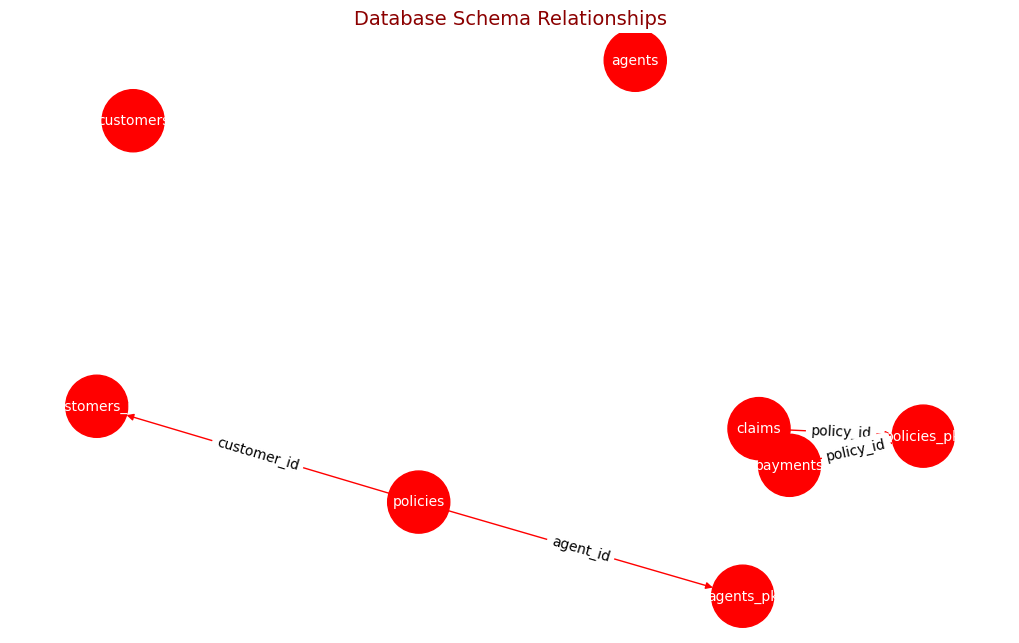

In [0]:
%python
import networkx as nx
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

tableR = spark.table("cat_prod.pega.table_relationships")
# Convert PySpark DataFrame to Pandas for easier visualization load the table
pandas_df = tableR.toPandas()

# Create a directed graph
G = nx.DiGraph()
# Add nodes (tables)
for table in pandas_df["TableName"]:
    G.add_node(table, color="red")

# Add edges (relationships)
for _, row in pandas_df.iterrows():
    if row["Relations"] is not None:  # Avoid None values
        for relation in row["Relations"]:
            related_table = relation["RelatedTable"]
            key_column = relation["KeyColumn"]
            G.add_edge(row["TableName"], related_table, label=key_column)

# Set up visualization properties
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G)  # Layout algorithm for better positioning

# Draw nodes
node_colors = [G.nodes[n].get("color", "red") for n in G.nodes]
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="red", node_size=2000, font_size=10, font_color="white")

# Draw edge labels
edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="black")

# Show the graph
plt.title("Database Schema Relationships", fontsize=14, color="darkred")
plt.show()